# Name Collection

In [ ]:
!wget https://raw.githubusercontent.com/ygtxr1997/CelebBasis/main/infer_images/wiki_names.txt

In [ ]:
!wget https://raw.githubusercontent.com/ygtxr1997/CelebBasis/main/infer_images/celebs.txt

In [ ]:
from pathlib import Path

#with Path('wiki_names.txt').open() as f:
with Path('celebs.txt').open() as f:
    wiki_names = f.read().split('\n')

len(wiki_names) # 1109

first_names = [n for n in set([name.split(' ')[0] for name in wiki_names]) if '.' not in n]
last_names = [n for n in set([name.split(' ')[-1] for name in wiki_names]) if '.' not in n]

len(first_names), len(last_names)

In [ ]:
first_names[:10]

In [ ]:
last_names[:10]

# Image Generation

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionPipeline.from_pretrained(
                model_id,
                revision="fp16",
                #torch_dtype=torch.float16,
                #use_auth_token=True
            ).to('cuda')

In [ ]:
#"diffusers",
#    "EulerDiscreteScheduler"
#pipe.scheduler
import diffusers
#pipe.scheduler = diffusers.EulerDiscreteScheduler()
# https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/blob/main/scheduler/scheduler_config.json
true, false, null = True, False, None
pipe.scheduler = diffusers.EulerDiscreteScheduler(
    **{
      #"_class_name": "EulerDiscreteScheduler",
      #"_diffusers_version": "0.19.0.dev0",
      "beta_end": 0.012,
      "beta_schedule": "scaled_linear",
      "beta_start": 0.00085,
      #"clip_sample": false,
      "interpolation_type": "linear",
      "num_train_timesteps": 1000,
      "prediction_type": "epsilon",
      #"sample_max_value": 1.0,
      #"set_alpha_to_one": false,
      #"skip_prk_steps": true,
      "steps_offset": 1,
      "timestep_spacing": "leading",
      "trained_betas": null,
      "use_karras_sigmas": false
    }
)

In [ ]:
diffusers.EulerDiscreteScheduler()

In [ ]:
kwargs = dict(
    num_inference_steps=25,
    num_images_per_prompt=1,
    
)
prompt = "a painting of an apple"
outv = pipe(prompt, **kwargs)

In [ ]:
outv.images[0]

In [ ]:
# 1. loop over names
# 2. create folder for names
# 3. generate images, save to folder
# 4. compute CLIP/DINO image embeddings, save to folder

# ---

# let's start with 10 names and prototype this procedure generally.
# an important hyper parameter to start with will be the number of images per name.
# let's start by generating an unnecessary number of images for this first group, say 20-100.
# then use these to compute our diversity measures, and calibrate how many images we need by how many images it generally takes to get this measure to converge.


In [ ]:
#pipe.requires_safety_checker=False

In [ ]:
def passthrough(images, *args, **kargs):
    return images, [False for _ in images]
pipe.safety_checker = passthrough

In [ ]:
import time

#names = ["david"] ## TODO: dev
names = first_names

kwargs = dict(
    num_inference_steps=25,
    num_images_per_prompt=8
)

root = Path("images")

images_per_prompt = 24 #40

for name in names:
    #prompt = name
    print(name)
    prompt = f"a photo of {name}, portrait photography, full color, face full frame"
    prompt = prompt.lower().strip()
    
    prompt_clean = prompt.replace(',','')
    outdir = root / prompt_clean.replace(' ','_')  
    outdir.mkdir(parents=True, exist_ok=True)
    while len(list(outdir.glob('*.png'))) < images_per_prompt:
        outv = pipe(prompt, **kwargs)
        if any(outv.nsfw_content_detected):
            #continue
            break

        for idx,im in enumerate(outv.images):
            # would prefer to name images by seed, but hf is makes it hard.
            fname = outdir / f"{int(time.time())}_{idx}.png" 
            im.save(fname)


In [ ]:
# let's generate a shit load of images 
# for a few high-bias names as a calibration control
# for sensitivity analysis.

high_bias_names = [
    "oprah",
    "keanu",
    "cher",
    "beyoncé",
    "shaquille",
    "rihanna",
    "anupam",
]

images_per_prompt = 200


for name in high_bias_names:
    #prompt = name
    print(name)
    prompt = f"a photo of {name}, portrait photography, full color, face full frame"
    prompt = prompt.lower().strip()
    
    prompt_clean = prompt.replace(',','')
    outdir = root / prompt_clean.replace(' ','_')  
    outdir.mkdir(parents=True, exist_ok=True)
    while len(list(outdir.glob('*.png'))) < images_per_prompt:
        outv = pipe(prompt, **kwargs)
        if any(outv.nsfw_content_detected):
            #continue
            break

        for idx,im in enumerate(outv.images):
            # would prefer to name images by seed, but hf is makes it hard.
            fname = outdir / f"{int(time.time())}_{idx}.png" 
            im.save(fname)

# Image embedding

In [67]:
import torch

dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
#dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
#dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
#dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /home/dmarx/.cache/torch/hub/main.zip
/home/dmarx/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/dmarx/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/dmarx/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /home/dmarx/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:10<00:00, 8.79MB/s]


In [68]:
backbone_model = dinov2_vits14
backbone_model.eval()
backbone_model.cuda()

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [98]:
#im.getexif()
import numpy as np
x = torch.tensor(np.array(im.resize([560,560]))).unsqueeze(0).cuda()
x=x.transpose(3,1)
x=x.float()

In [99]:
# TODO: would be nice if images were of some size that
# had 8 and 14 as a common factor.
# 560 x 560 is probably a good option.
# 896 would also have 64 as a common factor.
outv = backbone_model.forward_features(x)
outv.keys()

dict_keys(['x_norm_clstoken', 'x_norm_patchtokens', 'x_prenorm', 'masks'])

In [104]:
for k in outv.keys():
    if outv[k] is not None:
        print((k,outv[k].shape))

('x_norm_clstoken', torch.Size([1, 384]))
('x_norm_patchtokens', torch.Size([1, 1600, 384]))
('x_prenorm', torch.Size([1, 1601, 384]))


In [107]:
# run through images in a folder, project each into the clstoken and persist
# q: numpy or torch tensor? not that it super matters.

def image2dino(image):
    # prep image
    x = torch.tensor(np.array(image.resize([560,560]))).unsqueeze(0).cuda()
    x=x.transpose(3,1)
    x=x.float()
    
    # project
    outv = backbone_model.forward_features(x)
    return outv['x_norm_clstoken']

embed = image2dino(im)
embed.shape

torch.Size([1, 384])

In [122]:
# 1. glob images from folder
# 2. load iamge
# 3. project image
# 4. construct outname from inname
# 5. persist embed

import PIL

#outdir
emb_suffix = ".dinov2_cls.embed"
image_paths = outdir.glob('*.png')
# to do: glob embeds, only project images that we haven't already embedded
with torch.no_grad():
    for fpath in image_paths:
        im = PIL.Image.open(fpath)
        embed = image2dino(im)
        embed_path = outdir / (fpath.stem + emb_suffix)
        #torch.save(embed, embed_path) # 2.3mb for a 1x384 vector? wtf?
        arr = np.array(embed.cpu())
        np.save(embed_path, arr) # adds ".npy" extension. whatever.
        #break


In [142]:
# 1. load embeddings
# 2. compute cumulative variance
# 3. plot variance convergence

embed_paths = outdir.glob('*.embed.*')
embeds = []
for fpath in embed_paths:
    embed = np.load(fpath)
    embeds.append(embed)

V = []
for i in range(3, len(embeds)+1):
    x = np.concatenate(embeds[:i]) #.shape
    cv = np.cov(x.T)
    #np.linalg.det(cv) # :(
    v = np.trace(cv) / cv.shape[-1]
    V.append(v)

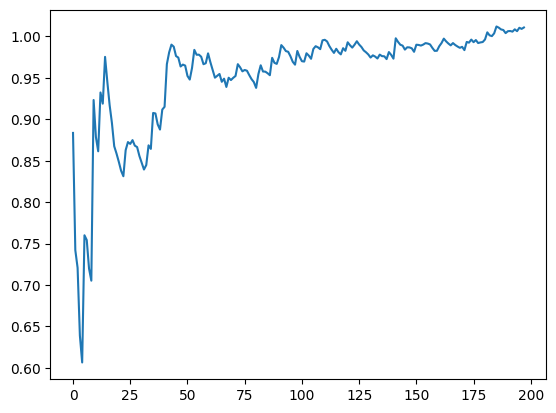

In [144]:
import matplotlib.pyplot as plt
plt.plot(V)

# TODO

* [ ] filtter out images with more than one face in them (check and report on what gets pulled out)
* [ ] calibrate # images for experiments
  * "power analysis" - how many images do we need to detect the variance threshold we're interested in?"
* [ ] DINOv2 embeddings
* [ ] upload images to HF
* [ ] per-prompt (cluster) summary statistics
* [ ] tSNE
* [ ] separately generate and save input clip emberddings of prompts
* [ ] score images relative to centroid in addition to summary statistic for cluster
* [ ] repeat procedure across several checkpoints, compare per-cluster summary statistics across checkpoints. expect to observe narrowing of biases as checkpoints are progressively finetuned.

In [ ]:
# DINOv2 embeddings